This notebook is modified from this source [Root cause analysis (RCA)](https://www.pywhy.org/dowhy/v0.8/example_notebooks/rca_microservice_architecture.html#)

# Root cause analysis (RCA) of latencies in a microservice architecture
In this case study, we identify the root causes of “unexpected” observed latencies in cloud services that empower an online shop. We focus on the process of placing an order, which involves different services to make sure that the placed order is valid, the customer is authenticated, the shipping costs are calculated correctly, and the shipping process is initiated accordingly. The dependencies of the services is shown in the graph below.

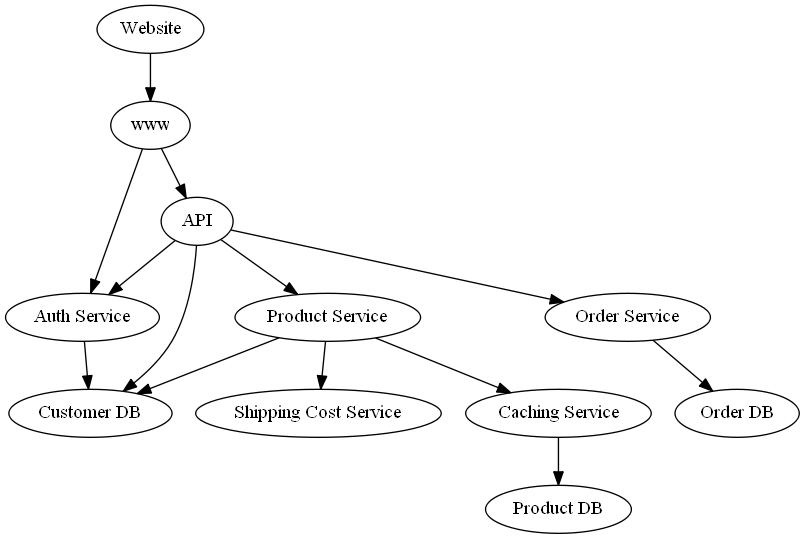

In [1]:
from IPython.display import Image
Image('figures/microservice-architecture-dependencies.png', width=500)

This kind of dependency graph could be obtained from services like [Amazon X-Ray](https://aws.amazon.com/de/xray/) or defined manually based on the trace structure of requests.

We assume that the dependency graph above is correct and that we are able to measure the latency (in seconds) of each node for an order request. In case of Website, the latency would represent the time until a confirmation of the order is shown. For simplicity, let us assume that the services are synchronized, i.e., a service has to wait for downstream services in order to proceed. Further, we assume that two nodes are not impacted by unobserved factors (hidden confounders) at the same time (i.e., causal sufficiency). Seeing that, for instance, network traffic affects multiple services, this assumption might be typically violated in a real-world scenario. However, weak confounders can be neglected, while stronger ones (like network traffic) could falsely render multiple nodes as root causes. Generally, we can only identify causes that are part of the data.

In [3]:
import pandas as pd

normal_data = pd.read_csv("data/rca_microservice_architecture_latencies.csv")
normal_data.head()

,Unnamed: 0,Product DB,Customer DB,Order DB,Shipping Cost Service,Caching Service,Product Service,Auth Service,Order Service,API,www,Website
0,0,0.383661,0.172658,0.225864,0.414972,0.567850,0.808292,0.281689,1.022173,2.852116,3.207333,3.369376
1,1,0.021331,0.158365,0.423773,0.233531,0.148977,0.495680,0.307202,1.105642,3.008470,3.376257,3.418782
2,2,0.438745,0.023790,0.374787,0.174145,0.107959,0.275520,0.253764,0.991932,2.342143,2.715196,2.903347
3,3,0.281268,0.071745,0.357236,0.265431,0.426341,0.754384,0.260964,1.358741,3.242781,3.611260,3.809622
4,4,0.019161,0.748138,0.125844,0.359678,0.168281,0.912594,1.036690,0.713691,3.961797,5.143582,5.304622


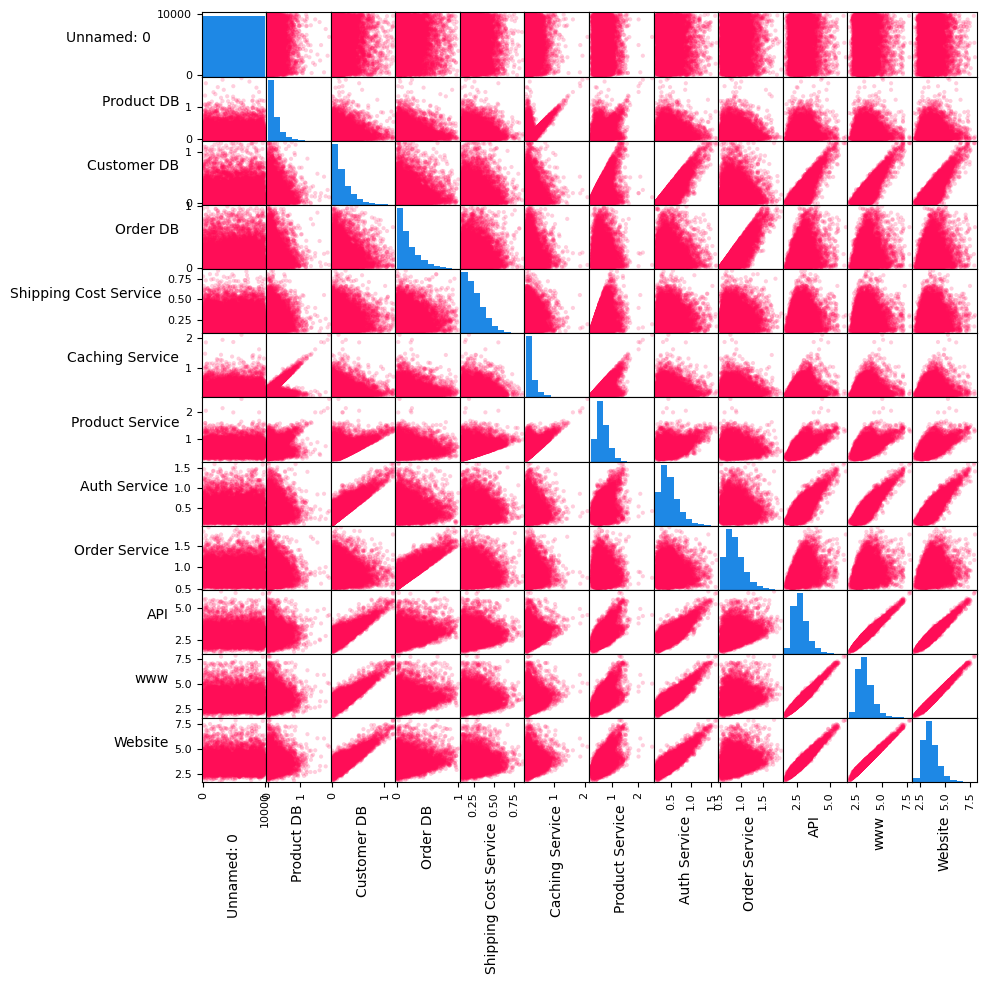

In [2]:
axes = pd.plotting.scatter_matrix(normal_data, figsize=(10, 10), c='#ff0d57', alpha=0.2, hist_kwds={'color':['#1E88E5']});
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

In the matrix above, the plots on the diagonal line are histograms of variables, whereas those outside of the diagonal are scatter plots of pair of variables. The histograms of services without a dependency, namely Customer DB, Product DB, Order DB and Shipping Cost Service, have shapes similar to one half of a Gaussian distribution. The scatter plots of various pairs of variables (e.g., API and www, www and Website, Order Service and Order DB) show linear relations. We shall use this information shortly to assign generative causal models to nodes in the causal graph.

In [3]:
import networkx as nx
from dowhy import gcm

causal_graph = nx.DiGraph([('www', 'Website'),
                           ('Auth Service', 'www'),
                           ('API', 'www'),
                           ('Customer DB', 'Auth Service'),
                           ('Customer DB', 'API'),
                           ('Product Service', 'API'),
                           ('Auth Service', 'API'),
                           ('Order Service', 'API'),
                           ('Shipping Cost Service', 'Product Service'),
                           ('Caching Service', 'Product Service'),
                           ('Product DB', 'Caching Service'),
                           ('Customer DB', 'Product Service'),
                           ('Order DB', 'Order Service')])

c:\Users\Bertram Taetz\gitRepos\DLMAIIAC\Sprint_November_2024\Session_6\venv_apps\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


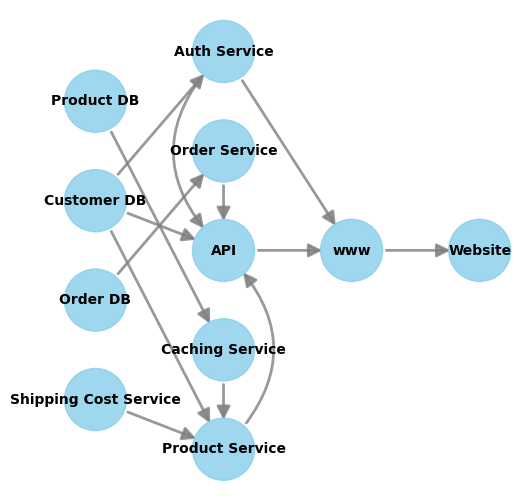

In [4]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [13, 13] # Make plot bigger

gcm.util.plot(causal_graph)

We will use the information from the pair-wise scatter plots and histograms to manually assign causal models. In particular, we assign half-Normal distributions to the root nodes (i.e., Customer DB, Product DB, Order DB and Shipping Cost Service). For non-root nodes, we assign linear additive noise models (which scatter plots of many parent-child pairs indicate) with empirical distribution of noise terms.

In [5]:
from scipy.stats import halfnorm

causal_model = gcm.StructuralCausalModel(causal_graph)

for node in causal_graph.nodes:
    if len(list(causal_graph.predecessors(node))) > 0:
        causal_model.set_causal_mechanism(node, gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
    else:
        causal_model.set_causal_mechanism(node, gcm.ScipyDistribution(halfnorm))

Alternatively, we can also automate this if we don’t have prior knowledge or are not familiar with the statistical implications:

In [10]:
gcm.auto.assign_causal_mechanisms(causal_model, normal_data)

# Scenario 1: Observing permanent degradation of latencies
In the previous scenario, we attributed a single outlier latency in Website to services that are nodes in the causal graph, which is useful for anecdotal deep dives. Next, we consider a scenario where we observe a permanent degradation of latencies and we want to understand its drivers. In particular, we attribute the change in the average latency of Website to upstream nodes.

Suppose we get additional 1000 requests with higher latencies as follows.

In [4]:
import pandas as pd
outlier_data = pd.read_csv("data/rca_microservice_architecture_anomaly_1000.csv")
outlier_data.head()

,Unnamed: 0,Product DB,Customer DB,Order DB,Shipping Cost Service,Caching Service,Product Service,Auth Service,Order Service,API,www,Website
0,0,0.071187,0.258874,0.291541,0.399845,2.293812,2.475971,0.423361,1.036642,4.733895,5.286727,5.398247
1,1,0.151033,0.001787,0.511994,0.302066,2.101877,2.300659,0.221990,1.027173,4.150301,4.550958,4.850308
2,2,0.013586,0.131242,0.267364,0.154605,2.131927,2.413969,0.446955,0.842789,4.443752,4.968050,4.982021
3,3,0.108091,0.186037,0.431081,0.169209,2.226859,2.385132,0.603135,0.976649,4.747490,5.562724,5.638192
4,4,0.458063,0.072306,0.010465,0.525410,2.571590,2.695012,0.184094,0.591294,4.320150,4.706886,4.750178


We are interested in the increased latency of Website on average for 1000 requests which the customers directly experienced.

In [11]:
outlier_data['Website'].mean() - normal_data['Website'].mean()

The Website is slower on average (by almost 2 seconds) than usual. Why?

# Attributing permanent degradation of latencies at a target service to other services
To answer why Website is slower for those 1000 requests compared to before, we attribute the change in the average latency of Website to services upstream in the causal graph. We refer the reader to [Budhathoki et al., 2021](https://assets.amazon.science/b6/c0/604565d24d049a1b83355921cc6c/why-did-the-distribution-change.pdf) for scientific details behind this API. We will calculate a 95% bootstrapped confidence interval of our attributions and visualize them in a bar plot.

In [16]:
def bar_plot_with_uncertainty(median_attribs, uncertainty_attribs, ylabel='Attribution Score', figsize=(8, 3), bwidth=0.8, xticks=None, xticks_rotation=90):
    fig, ax = plt.subplots(figsize=figsize)
    yerr_plus = [uncertainty_attribs[node][1] - median_attribs[node] for node in median_attribs.keys()]
    yerr_minus = [median_attribs[node] - uncertainty_attribs[node][0] for node in median_attribs.keys()]
    plt.bar(median_attribs.keys(), median_attribs.values(), yerr=np.array([yerr_minus, yerr_plus]), ecolor='#1E88E5', color='#ff0d57', width=bwidth)
    plt.xticks(rotation=xticks_rotation)
    plt.ylabel(ylabel)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if xticks:
        plt.xticks(list(median_attribs.keys()), xticks)
    plt.show()

Estimating bootstrap interval...: 100%|██████████| 10/10 [02:10<00:00, 13.06s/it]


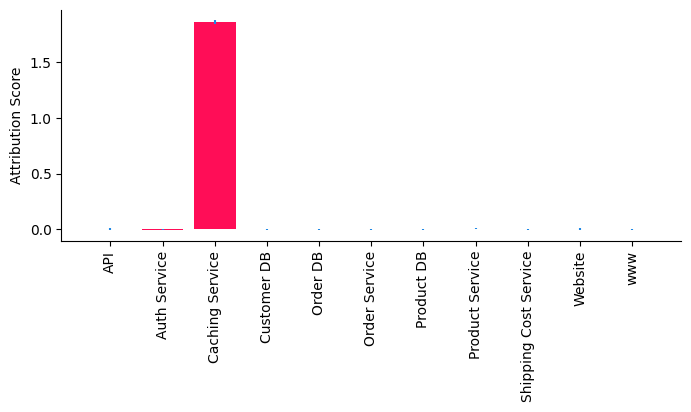

In [15]:
import numpy as np
median_attribs, uncertainty_attribs = gcm.confidence_intervals(
    lambda : gcm.distribution_change(causal_model,
                                     normal_data.sample(frac=0.6),
                                     outlier_data.sample(frac=0.6),
                                     'Website', # This is the attribute (outcome) for which the distribution change is being analyzed. It assumes that 'Website' is a variable in your causal model. 
                                     difference_estimation_func=lambda x, y: np.mean(y) - np.mean(x)),
    num_bootstrap_resamples = 10)

bar_plot_with_uncertainty(median_attribs, uncertainty_attribs)

We observe that Caching Service is the root cause that slowed down Website. In particular, the method we used tells us that the change in the causal mechanism (i.e., the input-output behaviour) of Caching Service (e.g., Caching algorithm) slowed down Website. This is also expected as the outlier latencies were generated by changing the causal mechanism of Caching Service (see Appendix below).

# Scenario 2: Simulating the intervention of shifting resources
Next, let us imagine a scenario where permanent degradation has happened as in scenario 1 and we’ve successfully identified Caching Service as the root cause. Furthermore, we figured out that a recent deployment of the Caching Service contained a bug that is causing the overloaded hosts. A proper fix must be deployed, or the previous deployment must be rolled back. But, in the meantime, could we mitigate the situation by shifting over some resources from Shipping Service to Caching Service? And would that help? Before doing it in reality, let us simulate it first and see whether it improves the situation.

![Image_shifting_resources](shifting-resources.png)

Let’s perform an intervention where we say we can reduce the average time of Caching Service by 1s. But at the same time we buy this speed-up by an average slow-down of 2s in Shipping Cost Service.

In [31]:
median_mean_latencies, uncertainty_mean_latencies = gcm.confidence_intervals(
    lambda : gcm.fit_and_compute(gcm.interventional_samples,
                                                 causal_model,
                                                 outlier_data,
                                                 interventions = {
                                                    "Caching Service": lambda x: x-1,
                                                    "Shipping Cost Service": lambda x: x + 2
                                                 },
                                                 observed_data=outlier_data)().mean().to_dict(),
    num_bootstrap_resamples=10)

Estimating bootstrap interval...: 100%|██████████| 10/10 [00:00<00:00, 39.57it/s]


Has the situation improved? Let’s visualize the results.

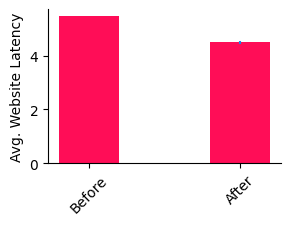

In [32]:
avg_website_latency_before = outlier_data.mean().to_dict()['Website']
bar_plot_with_uncertainty(dict(before=avg_website_latency_before, after=median_mean_latencies['Website']),
                          dict(before=np.array([avg_website_latency_before, avg_website_latency_before]), after=uncertainty_mean_latencies['Website']),
                          ylabel='Avg. Website Latency',
                          figsize=(3, 2),
                          bwidth=0.4,
                          xticks=['Before', 'After'],
                          xticks_rotation=45)